In [28]:
import json
from PIL import Image
import clip
from typing import List
import torch
from PIL import ImageFile
import os
import zipfile
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel

## Warning 

**This notebook requires a GPU to run efficiently.**
You can use a Cloud notebook with GPUs and try your the fine tuning of the model.

The fine-tuning runtime for a T4 GPU was 35 minutes

In [5]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Check for GPU availability
print(torch.cuda.is_available())
print(torch.cuda.device_count())

# If using GPU then use mixed precision training.
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device used", DEVICE)

False
0
Device used cpu


In [6]:
PATH_TO_ZIP_FILE = "../data/clip_data/Graph_dataset.zip"
DIRECTORY_TO_EXTRACT_TO = "../data/clip_data/dataset"
DATASET_DIRECTORY = os.path.join(DIRECTORY_TO_EXTRACT_TO, "graphs/")
PROCESSOR = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
MODEL = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Choose computation device
MODEL, PREPROCESS = clip.load("ViT-B/32", device=DEVICE, jit=False)

## Prerequisites

Download the zip dataset: https://www.kaggle.com/datasets/sunedition/graphs-dataset?resource=download 


Put the zip file in the input folder: '/data/clip_data' and run the next cell to unzip the dataset

In [8]:
# Unzip the directory
# with zipfile.ZipFile(PATH_TO_ZIP_FILE, 'r') as zip_ref:
#     zip_ref.extractall(DIRECTORY_TO_EXTRACT_TO)

The dataset directory contains images with prefix name equivalent to the label. 
We will consider:
- 'table' prefix is 'table' label
- 'just_images' prefix is 'other'
- the other labels prefixes are 'graph'


In [150]:
directory_to_extract_to = "../data/clip_data/dataset"
dataset_directory = os.path.join(directory_to_extract_to, "graphs/")
labels = []
images_path = []
for filename in os.listdir(dataset_directory):
    if filename.endswith(".jpg"):
        if filename.startswith("just_image"):
            labels.append("other")
        elif filename.startswith("table"):
            labels.append("table")
        else:
            labels.append("graph")
        images_path.append(os.path.join(dataset_directory, filename))

### Display an dataset image example

In [155]:
class CustomDataset():
    def __init__(self, list_image_path, list_txt):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        self.title = clip.tokenize(list_txt)

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        image = PREPROCESS(Image.open(self.image_path[idx]))
        title = self.title[idx]
        return image, title


def load_data():
    labels = []
    images_path = []
    for filename in os.listdir(DATASET_DIRECTORY):
        if filename.endswith(".jpg"):
            if filename.startswith("just_image"):
                labels.append("other")
            elif filename.startswith("table"):
                labels.append("table")
            else:
                labels.append("graph")
            images_path.append(os.path.join(DATASET_DIRECTORY, filename))
    return images_path, labels


# Function to convert model's parameters to FP32 format
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()


def train(train_dataloader):
    if DEVICE == "cpu":
        MODEL.float()

    optimizer = torch.optim.Adam(
        MODEL.parameters(), lr=5e-5, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.2)

    loss_img = nn.CrossEntropyLoss()
    loss_txt = nn.CrossEntropyLoss()

    num_epochs = 30
    for epoch in range(num_epochs):
        pbar = tqdm(train_dataloader, total=len(train_dataloader))
        for batch in pbar:
            optimizer.zero_grad()
            images, texts = batch
            images = images.to(DEVICE)
            texts = texts.to(DEVICE)

            # Forward pass
            logits_per_image, logits_per_text = MODEL(images, texts)

            # Compute loss
            ground_truth = torch.arange(
                len(images), dtype=torch.long, device=DEVICE)
            total_loss = (loss_img(logits_per_image, ground_truth) +
                          loss_txt(logits_per_text, ground_truth)) / 2

            # Backward pass
            total_loss.backward()

            if DEVICE == "cpu":
                optimizer.step()
            else:
                convert_models_to_fp32(MODEL)
                optimizer.step()
                clip.model.convert_weights(MODEL)

            pbar.set_description(
                f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")
    return total_loss, optimizer, MODEL

In [156]:
images_path, labels = load_data()
images_path = images_path[:10]
labels = labels[:10]

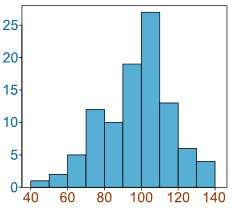

graph


In [159]:
from PIL import Image
from IPython.display import display

def display_image(image_path: str):
    img = Image.open(image_path)
    display(img)

display_image(images_path[0])
print(labels[0])

### Preprocess image and apply tokenizer to our labels

In [160]:
dataset = CustomDataset(images_path, labels)
train_data_loader = DataLoader(dataset, batch_size=1000, shuffle=True) #Define your own dataloader


In [23]:
total_loss, optimizer, model = train(train_data_loader)

Epoch 29/30, Loss: 0.0003: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


In [22]:
total_loss, optimizer, model = model

## Save the model

In [80]:
saved_model_path = f"../model/model_checkpoint/model_10.pt"
torch.save({
    'epoch': 30,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': total_loss,
}, saved_model_path)

In [103]:
DEVICE

'cpu'

# Load the model 

In [191]:
# Must set jit=False for training
saved_model_path = f"../model/model_checkpoint/doc_figure_model_10.pt"
model, preprocessor = clip.load("ViT-B/32", device=DEVICE, jit=False)
checkpoint = torch.load(saved_model_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Retry the long PDF image classification task from notebook 4 

In [192]:
def open_images_from_directory(directory_path):
    images = os.listdir(directory_path)
    images = [os.path.join(directory_path, img) for img in images]
    images = [Image.open(img) for img in images]
    return images

In [198]:
def predict(image: Image.Image, labels: List[str], model, preprocessor):
    image = preprocessor(image).unsqueeze(0).to(DEVICE)
    text = clip.tokenize(LABELS).to(DEVICE)

    with torch.no_grad():
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]
    return probs

In [199]:
DETECTED_IMAGE_DIRECTORY = "../data/pdf/extracted_images/long_pdf"
LABELS = ["graph", "table", "other"]
images = open_images_from_directory(DETECTED_IMAGE_DIRECTORY)

In [200]:
probs = []
for image in images:
    probs.append(
        predict(image=image, labels=LABELS, model=model, preprocessor=preprocessor))

In [201]:
probs

[array([0.77060795, 0.0654765 , 0.1639155 ], dtype=float32),
 array([0.7047481 , 0.09326691, 0.20198497], dtype=float32),
 array([0.8330568 , 0.04182005, 0.12512314], dtype=float32),
 array([0.6837945 , 0.10247575, 0.2137298 ], dtype=float32),
 array([0.68240124, 0.10369135, 0.21390748], dtype=float32),
 array([0.6369212 , 0.12495377, 0.23812495], dtype=float32),
 array([0.5596359 , 0.16562378, 0.27474028], dtype=float32),
 array([0.67843103, 0.10539997, 0.21616895], dtype=float32),
 array([0.9013516 , 0.01993929, 0.07870906], dtype=float32),
 array([0.86737704, 0.03018423, 0.10243867], dtype=float32),
 array([0.5455698 , 0.17393644, 0.28049374], dtype=float32),
 array([0.7846572 , 0.05965018, 0.15569267], dtype=float32),
 array([0.90064096, 0.02013871, 0.07922032], dtype=float32),
 array([0.77022636, 0.06562895, 0.16414462], dtype=float32),
 array([0.36925486, 0.2864974 , 0.3442477 ], dtype=float32),
 array([0.71279305, 0.08944432, 0.19776264], dtype=float32),
 array([0.90064096, 0.02

In [202]:
# Conservons les images qavec une probabilité sur les labels graphes et tableaux supérieures à 0.9
graphs_found = [[img, label_prob[0].item()] for (
    img, label_prob) in zip(images, probs) if label_prob[0].item() > 0.9]
tables_found = [[img, label_prob[1].item()] for (
    img, label_prob) in zip(images, probs) if label_prob[1].item() > 0.9]
other_found = [[img, label_prob[2].item()] for (img, label_prob) in zip(
    images, probs) if label_prob[0].item() <= 0.9 or label_prob[1].item() <= 0.9]

print(f'Graphs found: {len(graphs_found)}')
print(f'Tables found: {len(tables_found)}')
print(f'Other images found: {len(other_found)}')

Graphs found: 57
Tables found: 0
Other images found: 211


In [203]:
import numpy as np
import matplotlib.pyplot as plt


def display_multiple_images(images: List[Image.Image], probs: List[float]):
    # Max number of images to display
    images = images[:60]
    probs = probs[:60]

    columns = 4
    rows = (len(images) // columns) + 1
    fig = plt.figure(figsize=(9, 13))

    # ax enables access to manipulate each of subplots
    ax = []

    for i, img in enumerate(images):
        img = images[i]
        prob = np.round(probs[i], 3)
        # create subplot and append to ax
        ax.append(fig.add_subplot(rows, columns, i+1))
        ax[-1].axis("off")
        ax[-1].set_title("Proba:"+str(prob), fontsize=7)  # set title
        plt.imshow(img, alpha=0.9)

    plt.show()  # finally, render the plot

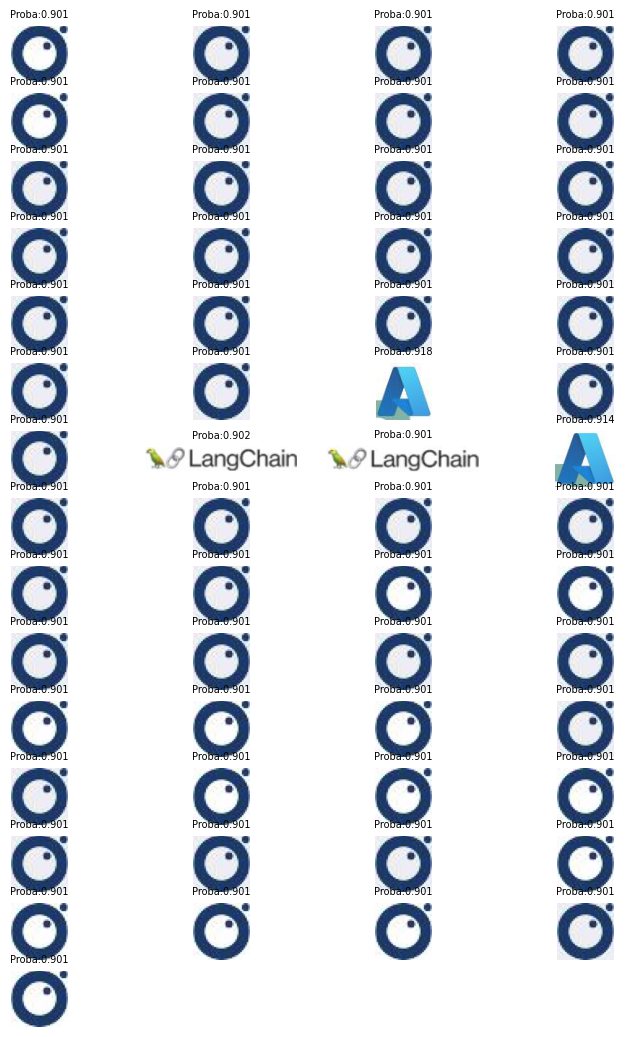

In [204]:
display_multiple_images([img[0] for img in graphs_found], [
                        img[1] for img in graphs_found])

In [205]:
display_multiple_images([img[0] for img in tables_found], [
                        img[1] for img in tables_found])

<Figure size 900x1300 with 0 Axes>

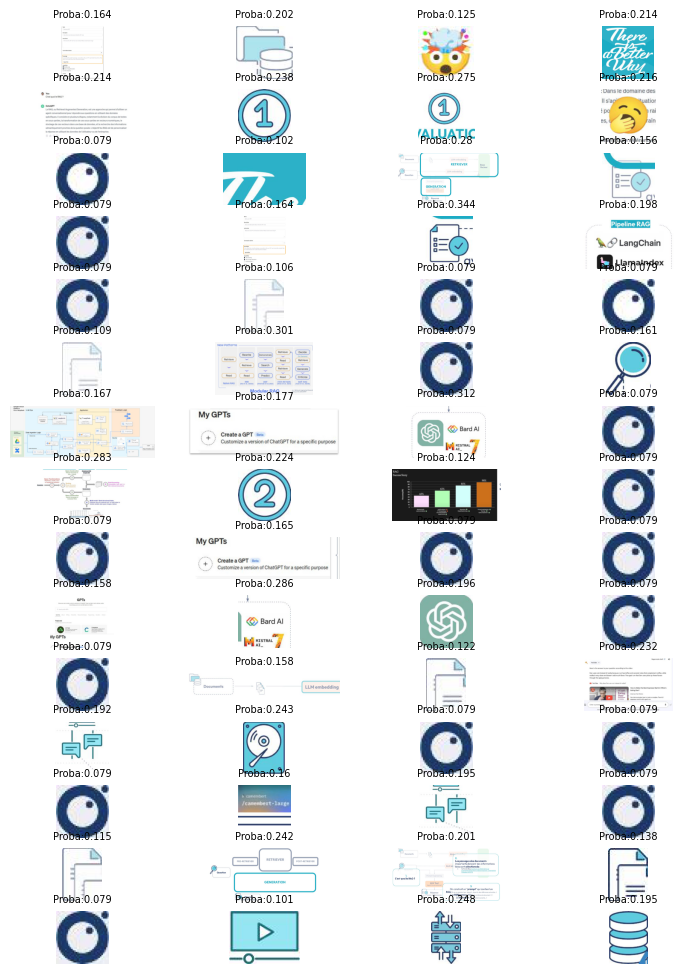

In [206]:
display_multiple_images([img[0] for img in other_found], [
                        img[1] for img in other_found])

In [131]:
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [132]:
model

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [148]:
for a,b in val_loader:
    print(b)
    break

# clip.tokenize(['graph'])

tensor([[49406,   608,   270,  2281,   270,  9289,   318,  2281,   270, 14876,
          1167,   270, 24670,   270, 22697,   318,  4952,   275,   271,   280,
           269, 36950,   269, 36950, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   608,   270,  2281,   270,  9289,   318,  2281,   270, 14876,
          1167,   270, 24670,   270,   761,   318,  2867,   318, 19859,   268,
          2368,   268,  6982,   269, 36950,   269, 36950, 49407,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

In [162]:
val_loader = train_data_loader
model.eval()
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()


with torch.no_grad():
    pbar = tqdm(val_loader, total=len(val_loader))
    for batch in pbar:
        optimizer.zero_grad()
        images, texts = batch
        images = images.to(DEVICE)
        texts = texts.to(DEVICE)

        # Forward pass
        logits_per_image, logits_per_text = model(image, texts)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]

        outputs = MODEL(images, texts)

        loss = criterion(outputs, labels)

        # Compute loss
        ground_truth = torch.arange(
            len(images), dtype=torch.long, device=DEVICE)
        total_loss = (loss_img(logits_per_image, ground_truth) +
                        loss_txt(logits_per_text, ground_truth)) / 2


# with torch.no_grad():
#     for images, labels in val_loader:
#         images = images.to(DEVICE)
#         labels = labels.to(DEVICE)

#         outputs = model(images, labels)
#         loss = criterion(outputs, labels)

#         val_loss += loss.item() * images.size(0)
#         _, preds = torch.max(outputs, 1)
#         val_acc += torch.sum(preds == labels.data)

#     val_loss = val_loss / len(val_dataset)
#     val_acc = val_acc / len(val_dataset)

print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

  0%|          | 0/1 [00:00<?, ?it/s]


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not tuple

In [164]:
model.save_pretrained("./clipChart", from_pt=True)

AttributeError: 'CLIP' object has no attribute 'save_pretrained'